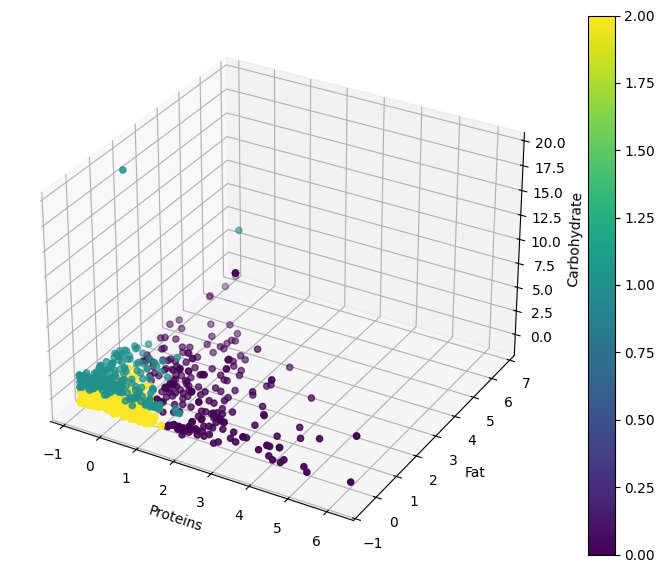

   id  calories  proteins   fat  carbohydrate                name  \
0   1     280.0       9.2  28.4           0.0                Abon   
1   2     513.0      23.7  37.0          21.3        Abon haruwan   
2   3       0.0       0.0   0.2           0.0           Agar-agar   
3   4      45.0       1.1   0.4          10.8  Akar tonjong segar   
4   5      37.0       4.4   0.5           3.8       Aletoge segar   

                                               image  cluster  
0  https://img-cdn.medkomtek.com/PbrY9X3ignQ8sVuj...        0  
1  https://img-global.cpcdn.com/recipes/cbf330fbd...        0  
2  https://res.cloudinary.com/dk0z4ums3/image/upl...        2  
3  https://images.tokopedia.net/img/cache/200-squ...        2  
4  https://nilaigizi.com/assets/images/produk/pro...        2  


In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset 
data = pd.read_csv('nutrition.csv')  

# Preprocess the data by selecting only the relevant columns
X = data[['proteins', 'fat', 'carbohydrate']]

# Standardize the features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Add the cluster labels to the original dataset
data['cluster'] = kmeans.labels_

#Visualize the clusters 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=data['cluster'], cmap='viridis')

# Add labels
ax.set_xlabel('Proteins')
ax.set_ylabel('Fat')
ax.set_zlabel('Carbohydrate')

# Add a color bar to show the cluster color
plt.colorbar(scatter)
plt.show()

# Step 7: Save the new dataset with cluster labels
data.to_csv('nutrition_clustered.csv', index=False)

# Step 8: Print the first few rows of the clustered data
print(data.head())


In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Calculate BMR (Basal Metabolic Rate)
def calculate_bmr(sex, age, weight, height, activity_level):
    if sex == 'male':
        bmr = 88.362 + (13.397 * weight) + (4.799 * height) - (5.677 * age)
    else:
        bmr = 447.593 + (9.247 * weight) + (3.098 * height) - (4.330 * age)
    
    # Adjust BMR based on activity level
    activity_multiplier = {
        'sedentary': 1.2,
        'light': 1.375,
        'moderate': 1.55,
        'active': 1.725,
        'very active': 1.9
    }
    bmr *= activity_multiplier.get(activity_level, 1.2)
    
    return bmr

# Step 2: Load the dataset 
data = pd.read_csv('nutrition_clustered.csv')  

# Step 3: Data Preprocessing
def preprocess_data(data):
    # Data cleaning: Dropping rows with missing values
    data = data.dropna()

    # Scaling: Standardize numerical columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[['calories', 'proteins', 'fat', 'carbohydrate']])
    scaled_df = pd.DataFrame(scaled_data, columns=['calories', 'proteins', 'fat', 'carbohydrate'])
    
    return scaled_df, scaler

# Preprocess the dataset
processed_data, scaler = preprocess_data(data)

# Step 4: Split data into features (X) and target (y)
X = processed_data[['proteins', 'fat', 'carbohydrate']]  # Features
y = processed_data['calories']  # Target 

# Step 5: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Model Training (Random Forest Regressor)
def train_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

rf_model = train_random_forest(X_train, y_train)

# Step 7: Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    return mse

evaluate_model(rf_model, X_test, y_test)

# Step 8: Model Optimization using GridSearchCV
def optimize_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

optimized_rf_model = optimize_model(X_train, y_train)

# Step 9: Final evaluation with optimized model
evaluate_model(optimized_rf_model, X_test, y_test)

# Step 10: Meal Recommendation based on User's Input and Optimized Model
def recommend_meals_high_protein_low_carb_no_pork(bmr, data, rf_model, protein_threshold=15, carb_threshold=20):
    # Allocate calories for meals and snacks
    breakfast_calories = bmr * 0.25
    lunch_calories = bmr * 0.35
    dinner_calories = bmr * 0.3
    snack_calories = bmr * 0.1  
    
    # Filter data for high protein, low carb, and no pork
    high_protein_low_carb_no_pork = data[
        (data['proteins'] >= protein_threshold) &
        (data['carbohydrate'] <= carb_threshold) &
        (~data['name'].str.contains('babi', case=False, na=False))
    ]
    
    # Function to find a combination of foods that sum up to target calories
    def find_foods(target_calories, data, max_items=3):
        # Try to find combinations of up to max_items that are <= target_calories
        for num_items in range(1, max_items + 1):
            possible_combinations = data.sample(n=num_items, replace=False)
            total_calories = possible_combinations['calories'].sum()
            if total_calories <= target_calories:
                return possible_combinations
        # If no combination found, return the food with closest lower calories
        closest_food = data[data['calories'] <= target_calories].sort_values('calories', ascending=False).head(1)
        return closest_food
    
    # Recommend meals
    breakfast_foods = find_foods(breakfast_calories, high_protein_low_carb_no_pork)
    lunch_foods = find_foods(lunch_calories, high_protein_low_carb_no_pork)
    dinner_foods = find_foods(dinner_calories, high_protein_low_carb_no_pork)
    snack_foods = find_foods(snack_calories / 2, high_protein_low_carb_no_pork, max_items=2)  # Two snacks
    
    return breakfast_foods, lunch_foods, dinner_foods, snack_foods

# Example user input
user_input = {
    'sex': 'male',
    'age': 30,
    'weight': 75,  # in kg
    'height': 175,  # in cm
    'activity_level': 'moderate'  # activity level (sedentary, light, moderate, active, very active)
}

# Step 11: Calculate BMR based on user input
bmr = calculate_bmr(user_input['sex'], user_input['age'], user_input['weight'], user_input['height'], user_input['activity_level'])

# Step 12: Recommend meals based on user's calorie needs and high protein, low carb
breakfast, lunch, dinner, snacks = recommend_meals_high_protein_low_carb_no_pork(bmr, data, optimized_rf_model)

# Step 13: Display the recommended meals
print("Rekomendasi Makanan")
print("\nBreakfast:")
print(breakfast[['name','calories', 'proteins', 'fat', 'carbohydrate']])
print("\nLunch:")
print(lunch[['name','calories', 'proteins', 'fat', 'carbohydrate']])
print("\nDinner:")
print(dinner[['name','calories', 'proteins', 'fat', 'carbohydrate']])
print("\nSnacks:")
print(snacks[['name','calories', 'proteins', 'fat', 'carbohydrate']])


Mean Squared Error (MSE): 0.1435492040166893
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
Mean Squared Error (MSE): 0.14095830545014384
Rekomendasi Makanan

Breakfast:
    name  calories  proteins   fat  carbohydrate
29  Ayam     302.0      18.2  25.0           0.0

Lunch:
                   name  calories  proteins   fat  carbohydrate
478  Ikan Mujair goreng     416.0      46.9  23.9           0.0

Dinner:
                   name  calories  proteins   fat  carbohydrate
1217  Telur Ayam ceplok     383.0      15.1  32.9           8.3

Snacks:
          name  calories  proteins  fat  carbohydrate
406  Hati Sapi     136.0      19.7  3.2           6.0
